# Topic keywords

Check which words are typical for topic tweets in different time frames

In [1]:
import csv
import math
import os
import pandas as pd
import re
import sys
from IPython.display import clear_output
from nltk.tokenize import TweetTokenizer
sys.path.append("/home/erikt/projects/newsgac/fasttext-runs")
import tscore

In [2]:
DATADIR = "/home/erikt/projects/puregome/data/text/"
ID = "id_str"
REPLYID = "in_reply_to_status_id_str"
TEXT = "text"
TOKEN = "token"
USER = "user"

## Count tweets with topic words

In [3]:
def showSpyPoint(text):
    clear_output(wait=True)
    print(text)

def countTweets(datePattern,query,spy=True):
    count = 0
    fileList = sorted(os.listdir(DATADIR))
    for inFileName in fileList:
        if re.search(datePattern,inFileName):
            if spy: showSpyPoint(inFileName)
            df = pd.read_csv(DATADIR+inFileName,compression="gzip",index_col=ID)
            for i in range(0,len(df)):
                text = df.iloc[i][TEXT]
                if re.search(query,text): count += 1
    return(count)

def countTweetsReplies(datePattern,query,spy=True):
    count = 0
    selectedIds = {}
    fileList = sorted(os.listdir(DATADIR))
    for inFileName in fileList:
        if re.search(datePattern,inFileName):
            if spy: showSpyPoint(inFileName)
            df = pd.read_csv(DATADIR+inFileName,compression="gzip",index_col=ID)
            for i in range(0,len(df)):
                text = df.iloc[i][TEXT]
                replyParent = df.iloc[i][REPLYID]
                if re.search(query,text) or replyParent in selectedIds: 
                    count += 1
                    idstr = df.index[i]
                    selectedIds[idstr] = True
    return(count)

In [ ]:
DATEPATTERN = "20200522"

for query in "corona corona|covid corona|covid|flattenthecurve corona|covid|blijfthuis corona|covid|rivm\
              corona|covid|mondkapje corona|covid|huisarts corona|covid|houvol corona|covid|zorg".split():
    count = countTweets(DATEPATTERN,query,spy=False)
    print(count,query)

In [ ]:
DATEPATTERN = "20200522"

for query in "corona corona|covid corona|covid|flattenthecurve corona|covid|blijfthuis corona|covid|rivm\
              corona|covid|mondkapje corona|covid|huisarts corona|covid|houvol corona|covid|zorg".split():
    count = countTweetsReplies(DATEPATTERN,query,spy=False)
    print(count,query)

**Note**: the query "zorg" produces many false positives. There are irrelevant types ("bezorgd" and "bezorgen"), irrelevant syntactical forms ("ik zorg dat" and "Zorg dat je") and even the correct sense is not always related to the pandemic topic ("zorg voor ouderen/gehandicapten").

## Find other relevant words in topic tweets

In [4]:
AT = r"@"
HASH = r"#"

def makeData(datePattern,query,spy=True):
    fileList = sorted(os.listdir(DATADIR))
    queryTokens = {}
    nonQueryTokens = {}
    for inFileName in fileList:
        if re.search(datePattern,inFileName):
            if spy: showSpyPoint(inFileName)
            df = pd.read_csv(DATADIR+inFileName,compression="gzip",index_col=ID)
            for i in range(0,len(df)):
                text = df.iloc[i][TEXT]
                if re.search(query,text):
                    for token in TweetTokenizer().tokenize(text.lower()): 
                        if re.search(r"[a-z]",token):
                            if not token in queryTokens: queryTokens[token] = 0
                            queryTokens[token] += 1
                else:
                    for token in TweetTokenizer().tokenize(text.lower()): 
                        if re.search(r"[a-z]",token):
                            if not token in nonQueryTokens: nonQueryTokens[token] = 0
                            nonQueryTokens[token] += 1
    return(queryTokens,nonQueryTokens)


def readData(fileName):
    return(pd.read_csv(fileName,index_col=TOKEN).to_dict())

def writeData(data,fileName):
    pd.DataFrame(data).to_csv(fileName,index_label=TOKEN)
    
def findKeysStartingWithChar(data,char):
    keysStartingWithChar = []
    for key in data:
        try:
            if re.search(r"^"+char+r"\w",key):
                shortKey = key[1:]
                if shortKey in data: keysStartingWithChar.append(shortKey)
        except: pass
    return(keysStartingWithChar)

def combineKeysStartingWithChar(data,char,keysStartingWithChar):
    for key in keysStartingWithChar:
        data[key] += data[char+key]
        del(data[char+key])
    return(data)

def combineInitialHashAt(data):
    keysStartingWithHash = findKeysStartingWithChar(data,HASH)
    data = combineKeysStartingWithChar(data,HASH,keysStartingWithHash)
    keysStartingWithAt = findKeysStartingWithChar(data,AT)
    data = combineKeysStartingWithChar(data,AT,keysStartingWithAt)
    return(data)

In [5]:
NBROFEXAMPLES = 20

def dictTopN(dictionary,n=NBROFEXAMPLES):
    return([(x[1],x[0]) for x in dictionary.items()][0:n])

In [6]:
NBROFTOKENS = "totalFreq"
NBROFTYPES = "nbrOfWords"
WORDFREQS = "wordFreqs"

def makeTscoreData(tokenList):
    data = { NBROFTOKENS:0, NBROFTYPES:0, WORDFREQS:{} }
    for token in tokenList:
        if not math.isnan(tokenList[token]):
            data[WORDFREQS][token] = tokenList[token]
            data[NBROFTYPES] += 1
            data[NBROFTOKENS] += tokenList[token]
    return(data)

def sortTscores(tscores):
    return({token:tscores[token] for token in sorted(tscores.keys(),key=lambda t:tscores[t],reverse=True)})

In [40]:
FILENAME202002 = "query-tokens-202002-202003.csv"
FILENAME202004 = "query-tokens-202004-202005.csv"
NON = "non-"
WEEKS = {"2020020[2-8]":"20200202","20200209|2020021[0-5]":"20200209","2020021[6-9]|2020022[0-2]":"20200216","2020022[3-9]":"20200223",\
         "2020030[1-7]":"20200301","2020030[89]|2020031[0-4]":"20200308","2020031[5-9]|2020032[01]":"20200315","2020032[2-8]":"20200322",\
                                   "20200329|20200330|2020040[1-4]":"20200329",\
         "2020040[5-9]|2020041[01]":"20200405","2020041[2-8]":"20200412","20200419|2020042[0-5]":"20200419","2020042[6-9]|2020043|2020050[1-2]":"20200426",\
         "2020050[3-9]":"20200503","2020051[0-6]":"20200510","2020051[7-9]|2020052[0-3]":"20200517"}

In [ ]:
queryTokens202002 = readData(FILENAME202004)
nonQueryTokens202002 = readData(NON+FILENAME202004)
tscoresDataQuery = {}
tscoresDataNonQuery = {}
tscores = {}
for query in queryTokens202002:
    tscoresDataQuery[query] = makeTscoreData(combineInitialHashAt(queryTokens202002[query]))
    tscoresDataNonQuery[query] = makeTscoreData(combineInitialHashAt(nonQueryTokens202002[query]))
    print(query)
    tscores[query] = sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query]))
    for x in dictTopN(tscores[query]): print(round(x[0],1),x[1])

In [ ]:
# writeData(tscores,"tscores-202004-202005.csv")

In [7]:
tscores202002 = readData("tscores-202002-202003.csv")
tscores202004 = readData("tscores-202004-202005.csv")

In [35]:
TOPICS = "maatregelen mondkapje anderhalve   besmet rivm ".split()

data = {}
for topic in TOPICS:
    for date in tscores202002.keys():
        if not topic in data: data[topic] = {}
        data[topic][date] = tscores202002[date][topic]
    for date in tscores202004.keys():
        data[topic][date] = tscores202004[date][topic]

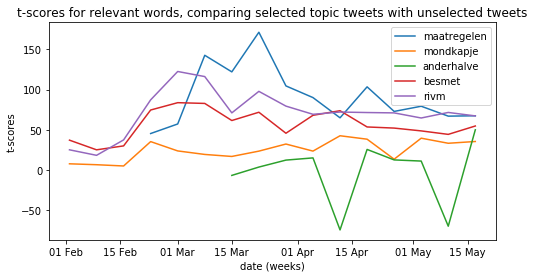

In [51]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

DATEFORMAT = "%Y%m%d"

fig,ax = plt.subplots(figsize=(8,4))
ax.xaxis.set_major_formatter(DateFormatter("%d %b"))
for topic in TOPICS:
    plt.plot_date([datetime.strptime(WEEKS[date],DATEFORMAT) for date in data[topic]],list(data[topic].values()),label=topic,fmt="-")
ax.set(xlabel="date (weeks)",ylabel="t-scores")
plt.title("t-scores for relevant words, comparing selected topic tweets with unselected tweets")
plt.legend()
plt.show()

**Note**: We expected only positive scores for topic words but the graph shows that *anderhalve* had negative scores  in two weeks. This means that most of the tweets containing this word are outside our topic tweets. We checked a sample of these missing tweets and most of them turned out to be on-topic, but they lacked the words *corona* and *covid*.

In [37]:
data["anderhalve"]

{'2020020[2-8]': nan,
 '20200209|2020021[0-5]': nan,
 '2020021[6-9]|2020022[0-2]': nan,
 '2020022[3-9]': nan,
 '2020030[1-7]': nan,
 '2020030[89]|2020031[0-4]': nan,
 '2020031[5-9]|2020032[01]': -6.78109277586768,
 '2020032[2-8]': 3.5968668157639,
 '20200329|20200330|2020040[1-4]': 12.25887915539494,
 '2020040[5-9]|2020041[01]': 14.994541390227027,
 '2020041[2-8]': -74.5804376462523,
 '20200419|2020042[0-5]': 25.531143924755014,
 '2020042[6-9]|2020043|2020050[1-2]': 12.490644526683235,
 '2020050[3-9]': 11.056992781834671,
 '2020051[0-6]': -69.95483007858873,
 '2020051[7-9]|2020052[0-3]': 49.94922692725938}

In [52]:
for date in tscores202002: 
    print("#####",date)
    for x in dictTopN(sortTscores(tscores202002[date]),n=50): print(round(x[0],1),x[1])
for date in tscores202004:
    print("#####",date)
   for x in dictTopN(sortTscores(tscores202004[date]),n=50): print(round(x[0],1),x[1])

In [ ]:
queryTokens202004 = readData(FILENAME202004)
nonQueryTokens202004 = readData(NON+FILENAME202004)
for query in queryTokens202004:
    tscoresDataQuery[query] = makeTscoreData(combineInitialHashAt(queryTokens202004[query]))
    tscoresDataNonQuery[query] = makeTscoreData(combineInitialHashAt(nonQueryTokens202004[query]))
    print(query)
    for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query]))): print(round(x[0],1),x[1])

In [ ]:
#writeData(queryTokens,"query-tokens-202004-202005.csv")
#writeData(nonQueryTokens,"non-query-tokens-202004-202005.csv")

In [ ]:
query = "2020051[7-9]|2020052[0-3]"
for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query])),n=40): print(round(x[0],1),x[1])

In [ ]:
DATEPATTERN = "20200[2345]06" 
QUERY= "zorg"

queryTokens = {}
nonQueryTokens = {}
tscoresDataQuery = {}
tscoresDataNonQuery = {}
queryTokens[DATEPATTERN],nonQueryTokens[DATEPATTERN] = makeData(DATEPATTERN,QUERY)
tscoresDataQuery[DATEPATTERN] = makeTscoreData(queryTokens[DATEPATTERN])
tscoresDataNonQuery[DATEPATTERN] = makeTscoreData(nonQueryTokens[DATEPATTERN])
for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[DATEPATTERN],tscoresDataNonQuery[DATEPATTERN])),n=40): print(round(x[0],1),x[1])

**Note**: the query "zorg" produces many false positives. There are irrelevant types ("bezorgd" and "bezorgen"), irrelevant syntactical forms ("ik zorg dat" and "Zorg dat je") and even the correct sense is not always related to the pandemic topic ("zorg voor ouderen/gehandicapten").

## Estimate coverage of crawler by looking back for messages with replies

In [53]:
DATEPATTERN = "20200522"

fileList = sorted(os.listdir(DATADIR))
seenIds = {}
for inFileName in fileList:
    if re.search(DATEPATTERN,inFileName):
        df = pd.read_csv(DATADIR+inFileName,compression="gzip",dtype=str)
        known = 0
        unknown = 0
        for i in range(0,len(df)):
            idstr = df.iloc[i][ID]
            seenIds[idstr] = True
            replyParent = df.iloc[i][REPLYID]
            if str(replyParent) != "nan":
                if replyParent in seenIds: known += 1
                else: unknown += 1
        print("{0} {1:.3f}".format(inFileName,round(known/(known+unknown),3)))

20200522-00.out.gz 0.364
20200522-01.out.gz 0.449
20200522-02.out.gz 0.445
20200522-03.out.gz 0.447
20200522-04.out.gz 0.413
20200522-05.out.gz 0.330
20200522-06.out.gz 0.421
20200522-07.out.gz 0.465
20200522-08.out.gz 0.553
20200522-09.out.gz 0.638
20200522-10.out.gz 0.689
20200522-11.out.gz 0.734
20200522-12.out.gz 0.766
20200522-13.out.gz 0.785
20200522-14.out.gz 0.790
20200522-15.out.gz 0.792
20200522-16.out.gz 0.794
20200522-17.out.gz 0.791
20200522-18.out.gz 0.805
20200522-19.out.gz 0.823
20200522-20.out.gz 0.804
20200522-21.out.gz 0.800
20200522-22.out.gz 0.807
20200522-23.out.gz 0.799
